# How's 2021 going? Twitter Sentiment Analysis (NLP)

With this project I wanted to get familiar with the Natural Language Processing (NLP) techniques and answer the following questions:

- What are the most common words people use to describe 2021?
- What is the number of tweets with the positive, negative and neutral sentiment?
- What are the most common words used in positive, neutral and negative tweets?
- What are the most liked and retweeted posts?

The tools used include ***Tweepy*** (for mining tweets), ***Pandas*** (for data cleaning/wrangling), ***Tweet Preprocessor*** (for rapid tweet cleaning), ***NLTK*** (for tokenization, stopwords removal and POS tagging), ***Plotly***, ***Matplotlib*** and ***Word Cloud*** (for visualization).

### **Contents**

1.[Authorisation Codes](#Authorisation-Codes)

2.[Scraping Tweets with API](#Scraping-Tweets-with-API)

3.[Save to CSV via Pandas data frame](#Save-to-CSV-via-Pandas-data-frame)

4.[Data Loading, Exploration and Cleaning](#Data-Loading,-Exploration-and-Cleaning)

5.[Manual cleaning of the most used adjectives](#Manual-cleaning-of-the-most-used-adjectives)

6.[Visualisation for most used words and Word Cloud](#Visualisation-for-most-used-words-and-Word-Cloud)

7.[Sentiment Analysis with VADER](#Sentiment-Analysis-with-VADER)

8.[Visualising most used positive, negative, neutral adjectives and displaying most liked and retweeted tweets](#Visualising-most-used-positive,-negative,-neutral-adjectives-and-displaying-most-liked-and-retweeted-tweets)



In [ ]:
#If you run this via Google Colab please run this section and restart the Runtime (ctr + M + .), otherwise plotly will not update.
!pip install tweet-preprocessor #run this if you need to install preprocessor
!pip install vaderSentiment #run this if you need to install Vader
!pip install plotly==4.14.3 #plotly is already installed in Google Colab, but for the purposes of this project we need the latest version

In [ ]:
#Scraping
import tweepy # for tweet mining
import csv # to read and write csv files
import glob

#Processing
import pandas as pd
import preprocessor as p
import requests
import nltk
import string 
import re # In-built regular expressions library
from nltk.corpus import stopwords, state_union 
from nltk.tokenize import  word_tokenize
from nltk import pos_tag
from collections import Counter

#Visualisation
import plotly
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
from PIL import Image
import numpy as np

#Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# **Scrape**

### **Authorisation Codes**

In [ ]:
# Consumer_key and access_key generated from Twitter's developer account
CONSUMER_KEY = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
CONSUMER_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
ACCESS_KEY = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
ACCESS_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' 

In [ ]:
# Authorisation code
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET) # Pass in Consumer key and secret for authentication by API
auth.set_access_token(ACCESS_KEY, ACCESS_SECRET) # Pass in Access key and secret for authentication by API
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True) # Sleeps when API limit is reached

### **Scraping Tweets with API**

In [ ]:
def get_tweets_in_data_range(data, phrase, max_tweets, end_date, start_date = None, start_via_tweet_id = None):
  """Scrapes Tweets based on given phrase, beteen dates. Alternatively this can work via a range of start_tweet_id and end date"""
  search_query = phrase + " -filter:links AND -filter:retweets AND -filter:replies" #Exclude links, retweets, replies
  for i in tweepy.Cursor(api.search, q = search_query, since = start_date, until = end_date, since_id = start_via_tweet_id, lang = "en", tweet_mode = "extended").items(max_tweets):
    data.append([i.full_text, i.id, i.created_at, i.coordinates, i.retweet_count, i.favorite_count]) # Embedded Twitter parameters

In [ ]:
scraped_data = []
scraped_data.append(["text", "id", "time", "location", "retweet_count", "fav_count"])
PHRASE = "\"This year\""
MAX_TWEETS = 1 #Maximum number of tweets to scrape
START_DATE = '2021-03-20' #only last 7 days supported
END_DATE = '2021-03-26' #only last 7 days supported
get_tweets_in_data_range(scraped_data, PHRASE, MAX_TWEETS, END_DATE, START_DATE) #call to get tweets between date ranges 
#get_tweets_in_data_range(scraped_data, PHRASE, MAX_TWEETS, END_DATE, None, 1375235706382123011) #call to get tweets from a tweet ID to end date (note that the Start_date is set to "None" and an a start_via_tweet_id argument is given)
#get_tweets_in_data_range(scraped_data, PHRASE, MAX_TWEETS, END_DATE, None, scraped_data[1][1]) #use scraped_data[1][1] after calling "get_tweets_in_data_range" once to access the latest id from the last call (to update with latest data)


In [ ]:
# Run this to see the Embedded Twitter parameters
cursor = tweepy.Cursor(api.user_timeline, id='BillGates', tweet_mode = "extended").items(1)
for i in cursor:
  print(dir(i))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'display_text_range', 'entities', 'favorite', 'favorite_count', 'favorited', 'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'parse', 'parse_list', 'place', 'retweet', 'retweet_count', 'retweeted', 'retweeted_status', 'retweets', 'source', 'source_url', 'truncated', 'user']


### **Save to CSV via Pandas data frame**


In [ ]:
tweets = pd.DataFrame(scraped_data[1:],columns=scraped_data[0])
tweets_csv = tweets.to_csv('This_year.csv', index=True)  #saves a csv file with the data scraped
#print(tweets)

In [ ]:
# Bonus cell: if you run mulitple phrases and have few csv files with your tweets, use the below code to merge all .csv files into one
path = r'/content/'  # use your path
all_files = glob.glob(path + "/*.csv")

data = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0) # Convert each csv to a dataframe
    data.append(df)

data = pd.concat(data, axis=0, ignore_index=True) # Merge all dataframes
data = data.to_csv('tweets_full.csv', index=False) # safe to csv for further analysis

# **Data Processing and Sentiment Analysis**


### **Data Loading, Exploration and Cleaning**
I decided to limit the pre-processing to minimum, leaving the emojis, punctuation, upper letters because I found that VADER gives better results when it has an access to emojis or punctation.

VADER readme: https://github.com/cjhutto/vaderSentiment/blob/master/README.rst


In [ ]:
PATH = r'/content/tweets_full.csv' # use your path
data = pd.read_csv(PATH, index_col = None, header=0)


#print("Data shape: ", data.shape) #explore the data
#data.info() #explore the data
#data = data.drop('Unnamed: 0', axis=1) #drop any unnecesary columns 
#data.duplicated(subset = 'id').sum() #check if tweets repeat
#data.isna().any() #check for nan values
#data.isnull().sum()
#data = data.drop_duplicates(subset = ['id']) #drop repeating tweets based on  ID
#data = data.drop(['location'], axis=1)
#data.shape #explore the data to see if the columns were dropped
#data.head()

Data shape:  (37644, 7)


Unnamed: 0           0
text                 0
id                   0
time                 0
location         37643
retweet_count        0
fav_count            0
dtype: int64

In [ ]:
def preprocess_tweet(row): 
    text = row['text']
    p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.RESERVED)
    text = p.clean(text)
    return text

data['text'] = data.apply(preprocess_tweet, axis=1) # clean url, mentions, hashtags etc

In [ ]:
nltk.download('stopwords')  #download the stop words from nltk
nltk.download('punkt')  #download the tonekizer from nltk
nltk.download('averaged_perceptron_tagger') #downloand POS package from nltk
#print(stopwords.words('english')) #check the included stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
#helper function to clean tweets for tokenizing
def cleaning_and_tokenization(tweet):
    tweet = re.sub(r'\&\w*;', '', tweet) # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\$\w*', '', tweet) # Remove tickers
    tweet = tweet.lower() # To lowercase
    tweet = re.sub(r'#\w*', '', tweet) # Remove hashtags
    tweet = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', tweet) # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet) # Remove words with 2 or fewer letters
    tweet = re.sub(r'\s\s+', ' ', tweet) # Remove whitespace (including new line characters)
    tweet = tweet.lstrip(' ') # Remove single space remaining at the front of the tweet.
    tweet = ''.join(c for c in tweet if c <= '\uFFFF')  # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode
    p.set_options(p.OPT.EMOJI) # Remove remining emoji
    tweet = p.clean(tweet)
    tweet = tweet.translate(str.maketrans('', '', string.digits)) # Remove numeric values from text
    tweet = word_tokenize(tweet) # tokenize tweets 
    return tweet

data['tokens'] = data['text'].apply(cleaning_and_tokenization) # Creates new column 'tokens' with text ready for tokenization


# removing stopwords and tag Parts of Speech (POS)
def remove_stopwords_and_tag_POS(tweet):
  clean_words = []
  for word in tweet:
    if word not in stopwords.words('english'):  
      clean_words.append(word)
  clean_words = nltk.pos_tag(clean_words) #add POS tagged tokens
  return clean_words

data['tokens'] = data['tokens'].apply(remove_stopwords_and_tag_POS) # Updates the 'tokens' column with tagged POS words

In [ ]:
#data['time'] = pd.to_datetime(data['time'], format = "%Y-%m-%d %H:%M:%S.%f") # parse time column (not used in my analysis)


### **Manual cleaning of the most used adjectives**

I go through the most commonly used adjectives and make sure to remove words which don't contribute to an overall meaning (custom stopwords). To do this I display the most used adjectives and manually add them to a custom stop word list.


In [ ]:
#Display most used adjectives
tags = ['JJ', 'JJR', 'JJS'] # To check the tag codes: https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk
adjectives = []
for pair in data['tokens']:
  for tag in pair:
    if tag[1] in tags:
      adjectives.append(tag[0])

Counter(adjectives).most_common(50) # If any of the displayed adjectives doesn't fit the purpose of the analysis it should be added to the custom_stop_words list.

In [ ]:
custom_stop_words = ["last", "new", "many", "much", "next", "birthday",
                     "able","least", "sure","want","whole","single","due",
                     "ta","th","open","give","pick","cant","nd","wish",
                     "know","april","third","bday","win","end","album",
                     "hr","st","january","cant'","ive", "ima","online",
                     "enlist","american","top","free","old","current",
                     "live","high","early","ready","little","full","big",
                     "small", "green","red","annual","white","black","miss",
                     "pro", "na", "west", "halloween", "first", "second", "true",
                     "march", "festival","japanese","actual","come","mean",
                     "saturday","last","next", "low","past","local","huge"] #add more words

In [ ]:
#Remove custom stop words
most_used_words = []
for word in adjectives: 
    if word not in custom_stop_words: 
        most_used_words.append(word)

Counter(most_used_words).most_common(100)


### **Visualisation for most used words and Word Cloud**


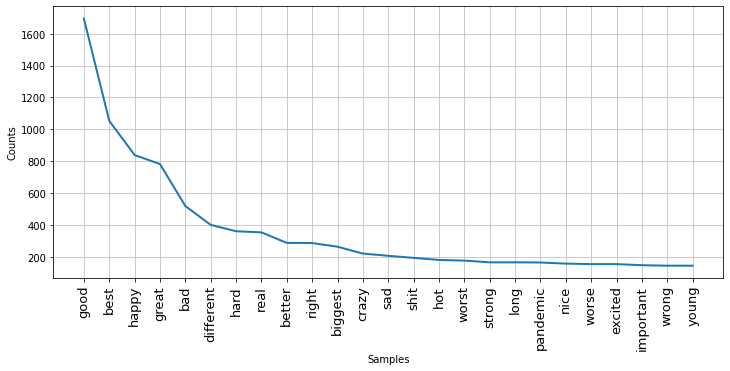

In [ ]:
# plot word frequency distribution of first few words
plt.figure(figsize = (12, 5))
plt.xticks(fontsize = 13, rotation = 90)
fd = nltk.FreqDist(most_used_words)
fd.plot(25, cumulative = False)

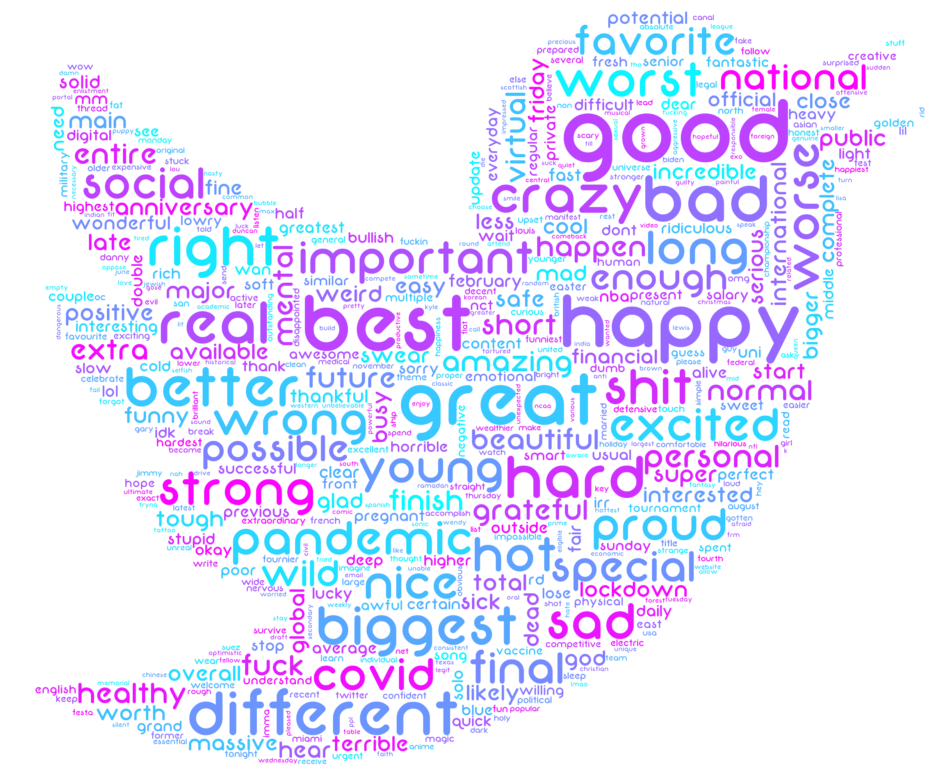

In [ ]:
wordfreq = Counter(most_used_words)
FONT = r'/content/Neon.ttf'
IMAGE =  r'/content/twitter.png'

mask = np.array(Image.open(IMAGE))
wordcloud = WordCloud(width = 900,
                      height = 500,
                      max_words = 500,
                      max_font_size = 256,
                      mask = mask,
                      background_color = "white",
                      font_path = FONT,
                      random_state = 42,
                      stopwords=STOPWORDS,
                      relative_scaling = 0.3,
                      colormap = 'cool',
                      repeat = False,
                      normalize_plurals = True).generate_from_frequencies(wordfreq)

plt.figure(figsize = (17, 14))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()


### **Sentiment Analysis with VADER**

In [ ]:
tweet_analyzer = SentimentIntensityAnalyzer()

#Creating new column with sentiment prdiction using VADER
sentiment = []
for tweet in data['text']:
    score = tweet_analyzer.polarity_scores(tweet)
    compound = score['compound']
    if compound > 0: compound = "positive"
    elif compound < 0: compound = "negative"
    else: compound = "neutral"
    sentiment.append(compound)
    
data['sentiment'] = sentiment

In [ ]:
#visualising the sentiment 
vis_data = pd.DataFrame(data['sentiment'].value_counts())
sentiment_label = ['positive', 'neutral', 'negative'] 
vis_data['sentiment_label'] = sentiment_label

fig = px.bar(vis_data, x='sentiment_label', y = 'sentiment',
            labels={'sentiment_label':' '},color = 'sentiment_label', 
            color_discrete_sequence = px.colors.qualitative.Pastel1)
fig.show()


### **Visualising most used positive, negative, neutral adjectives and displaying most liked and retweeted tweets**

In [ ]:
# function to extract adjectives and create Adjectives Column
def Adj_column(tweet): 
    tweet = [word for (word, tag) in tweet if tag in tags] 
    return " ".join(tweet)  # join words with a space in between them

data['adj_tweets'] = data['tokens'].apply(Adj_column)

In [ ]:
def append_most_common_via_sentiment_tag(sentiment_tag, most_common_count):
  split_array = []
  for line in data.loc[data['sentiment'] == sentiment_tag]['adj_tweets']: 
    for word in line.split():
      split_array.append(word)
  temp_df =  pd.DataFrame(data = Counter(split_array).most_common(most_common_count), columns=['word', 'count'])
  temp_df['sentiment'] = sentiment_tag
  return temp_df

combined_df = pd.concat([append_most_common_via_sentiment_tag('positive', 10), 
                         append_most_common_via_sentiment_tag('negative', 10), 
                         append_most_common_via_sentiment_tag('neutral', 10)], axis = 0)

fig = px.sunburst(combined_df, path = ['sentiment', 'word'], values = 'count',
                  color = 'sentiment', hover_data = ['count'],
                  color_discrete_sequence = ['rgb(179,205,227)', 'rgb(197,197,197)', 'rgb(251,180,174)'])
                  
fig.show()

In [ ]:
def create_table(table_values, labels):
  fig = go.Figure(data=[go.Table(
    columnorder = [1,2],
    columnwidth = [400,80],
    header = dict(
      values = labels,
      line_color='darkslategray',
      fill_color='royalblue',
      align=['center','center'],
      font=dict(color='white', size=12),
      height=40
    ),
    cells=dict(
      values=table_values,
      line_color='darkslategray',
      fill=dict(color=['rgb(159,200,255)', 'rgb(159,200,255)']),
      align=['left', 'center'],
      font_size=12,
      height=30)
      )
  ])
  fig.show()

In [ ]:
TOP_COUNT = 25
most_retweeted = [ 
         data.sort_values(by ='retweet_count', axis=0, ascending=False)[:TOP_COUNT]['text'],
         data.sort_values(by ='retweet_count', axis=0, ascending=False)[:TOP_COUNT]['retweet_count']]
most_retweeted_labels = ['<b>Top ' + str(TOP_COUNT) + ' Most Popular</b>','<b>Retweet Count</b>']

create_table(most_retweeted, most_retweeted_labels)

In [ ]:
most_liked = [ 
         data.sort_values(by ='fav_count', axis=0, ascending=False)[:TOP_COUNT]['text'],
         data.sort_values(by ='fav_count', axis=0, ascending=False)[:TOP_COUNT]['fav_count']]
most_retweeted_labels = ['<b>Top ' + str(TOP_COUNT) + ' Most Liked</b>','<b>Likes Count</b>']

create_table(most_liked, most_retweeted_labels)